## Task 2 - measuring quality of clustering algorithms 
The algorithms used are specified in the task (K-means, Genie, Agglomerative Hierarchical Clustering and DBSCAN)

The dataset used is from sipu collection available through https://github.com/gagolews/clustering-data-v1 reporistory. In this task we use 16 datasets instead of 18 because of memory problems when running the program for birch1, and birch2. all the datasets used are:  a1, a2, a3, aggregation, compound, d31, r15, flame, jain, pathbased, spiral,
 s1, s2, s3, s4, unbalance

In [2]:
import os
import numpy as np
import pandas as pd
import clustbench
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from genieclust import Genie
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score)

In [4]:
data_url = "https://github.com/gagolews/clustering-data-v1/raw/v1.1.0"
datasets = ['a1', 'a2', 'a3', 'aggregation', 'compound', 'd31', 'r15', 'flame', 'jain', 'pathbased', 'spiral', 's1', 's2', 's3', 's4', 'unbalance']

genie_params = [0.1, 0.3, 0.5, 0.7, 0.9]
agg_linkages = ['single', 'average', 'complete', 'ward']
dbscan_params = {'eps': [0.1, 0.2, 0.3, 0.5], 'min_samples': [3, 5, 10]}

metrics = ['ARI', 'NMI', 'FMI', 'Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']  ##https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

## Clustering Evaluation Metrics

# Based on metrics evaluation avilable in sklearn and often used in it I have decided to use the following:

- **Adjusted Rand Index (ARI)**  
  Measures how well the predicted clusters match the true labels, adjusting for chance. Scores range from –1 (bad) to 1 (perfect).

- **Normalized Mutual Information (NMI)**  
  Shows how much information is shared between clusters and true labels, scaled from 0 (none) to 1 (perfect).

- **Fowlkes–Mallows Index (FMI)**  
  Combines pairwise precision and recall into one score (0 to 1) to judge cluster/label agreement.

- **Silhouette Coefficient**  
  Compares each point’s similarity to its own cluster versus the next best cluster. Values near +1 mean well-separated groups.

- **Calinski–Harabasz Index**  
  Looks at the ratio of between-cluster spread to within-cluster spread; higher values indicate clearer separation.

- **Davies–Bouldin Index**  
  Averages how “similar” each cluster is to its closest neighbor; lower scores mean cleaner, tighter clusters.


# Following the evaluation cycle of clustering algorihms available in the article *A framework for benchmarking clustering algorithms* (SoftwareX 2022).

The steps are simple 

1. loading datasets and ground truth from sipu collection and their labels

2. running the experiment for each of the algorithm specified in the task 

3. generating labels with information from the evaluation function if the conditions are fullfileed (at least 2 labels for some of them)

4. Saving the results for each of the run in csv for easier processing (no need to rerun the algorithm for testing every time it is used)

Description of the approach is given in the task with sample codes as well
- https://clustering-benchmarks.gagolewski.com/index.html
- https://clustering-benchmarks.gagolewski.com/weave/true-vs-predicted.html
- https://clustering-benchmarks.gagolewski.com/weave/noise-points.html
- https://clustering-benchmarks.gagolewski.com/weave/many-partitions.html

In [5]:
def evaluate_clustering(X, y_true, clustering_algorithm):
    """
    Evaluate clustering performance using various metrics,
    but only compute Silhouette / Calinski-Harabasz / Davies-Bouldin
    if there are at least 2 clusters.
    """
    y_pred = clustering_algorithm.fit_predict(X)

    results = {
        'ARI': adjusted_rand_score(y_true, y_pred),
        'NMI': normalized_mutual_info_score(y_true, y_pred),
        'FMI': fowlkes_mallows_score(y_true, y_pred),
    }

    # count unique labels to chech if we can compute the other metrics
    n_labels = len(np.unique(y_pred))
    if n_labels >= 2 and n_labels <= len(y_pred) - 1:
        results['Silhouette']          = silhouette_score(X, y_pred)
        results['Calinski-Harabasz']   = calinski_harabasz_score(X, y_pred)
        results['Davies-Bouldin']      = davies_bouldin_score(X, y_pred)
    else:
        results['Silhouette']          = np.nan
        results['Calinski-Harabasz']   = np.nan
        results['Davies-Bouldin']      = np.nan

    return results

In [ ]:
def run_experiment(X, y_true, n_clusters):
    records = []
    
    # KMeans, with three different seeds
    for i in range(3):
        seed = 42 + i
        kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
        metrics = evaluate_clustering(X, y_true, kmeans)
        record = {
            'method': 'KMeans',
            'param': f'random_state={seed}',
            **metrics
        }
        records.append(record)
    
    # Agglomerative Clustering
    for linkage in agg_linkages:
        agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        metrics = evaluate_clustering(X, y_true, agg)
        records.append({
            'method': 'Agglomerative',
            'param': f'linkage={linkage}',
            **metrics
        })
    
    # DBSCAN
    for eps in dbscan_params['eps']:
        for min_samples in dbscan_params['min_samples']:
            dbs = DBSCAN(eps=eps, min_samples=min_samples)
            metrics = evaluate_clustering(X, y_true, dbs)
            records.append({
                'method': 'DBSCAN',
                'param': f'eps={eps}, min_samples={min_samples}',
                **metrics
            })
    
    # Genie
    for t in genie_params:
        genie = Genie(n_clusters=n_clusters)
        metrics = evaluate_clustering(X, y_true, genie)
        records.append({
            'method': 'Genie',
            'param': f'threshold={t}',
            **metrics
        })
    
    # turn the list of dicts into a DataFrame
    df = pd.DataFrame.from_records(records)
    return df
    

In [ ]:
if not os.path.exists('./benchmark_metrics.csv'):
    all_results = []

    for name in datasets:
        print(f"Dataset processing: {name}")
        bench = clustbench.load_dataset('sipu', name, url = data_url)
        X, y_true = bench.data, bench.labels[0]
        n_clusters = bench.n_clusters[0]
        df_res = run_experiment(X, y_true, n_clusters)
        for entry in df_res.to_dict('records'):
            entry['dataset'] = name
            all_results.append(entry)
    df = pd.DataFrame(all_results)
    df.to_csv('benchmark_metrics.csv', index = False)
else:
    df = pd.read_csv('./benchmark_metrics.csv')

Dataset processing: a1
Dataset processing: a2
Dataset processing: a3
Dataset processing: aggregation
Dataset processing: compound
Dataset processing: d31
Dataset processing: r15
Dataset processing: flame
Dataset processing: jain
Dataset processing: pathbased
Dataset processing: spiral
Dataset processing: s1
Dataset processing: s2
Dataset processing: s3
Dataset processing: s4
Dataset processing: unbalance


# Boxplots for each of the algorithm aggregated for all datasets


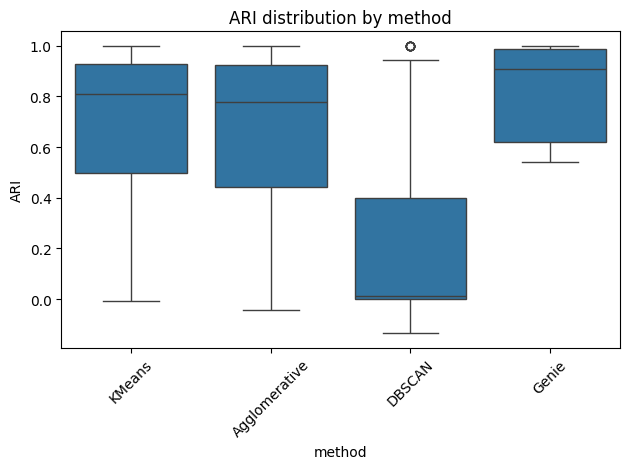

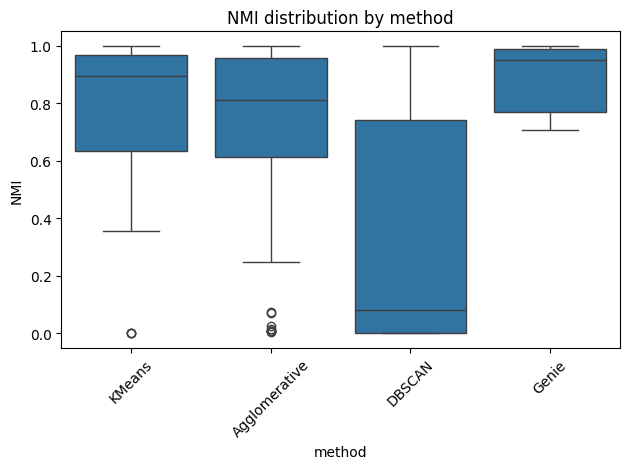

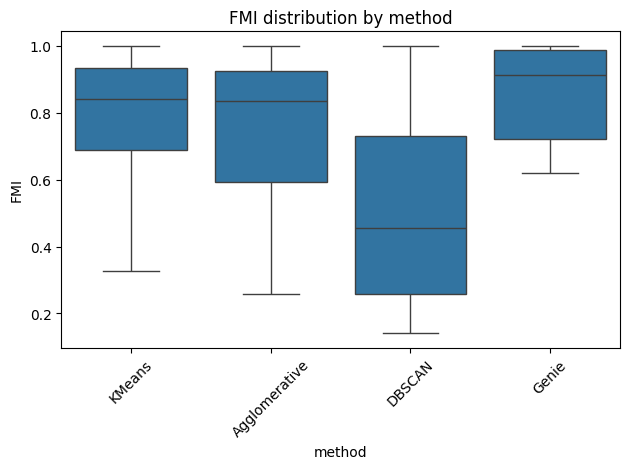

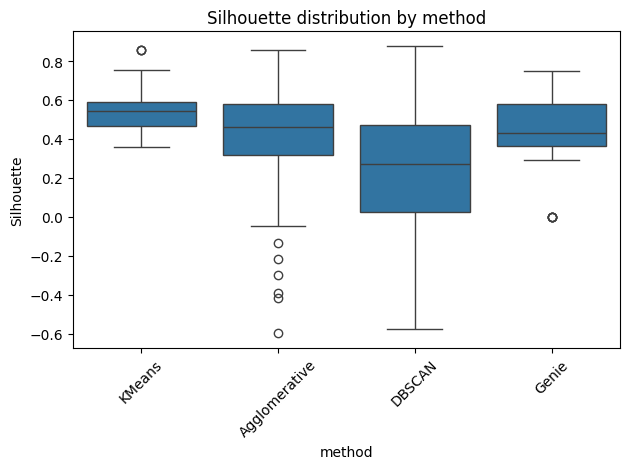

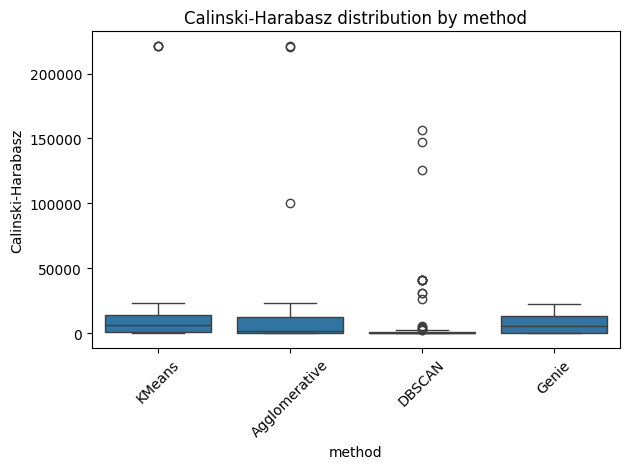

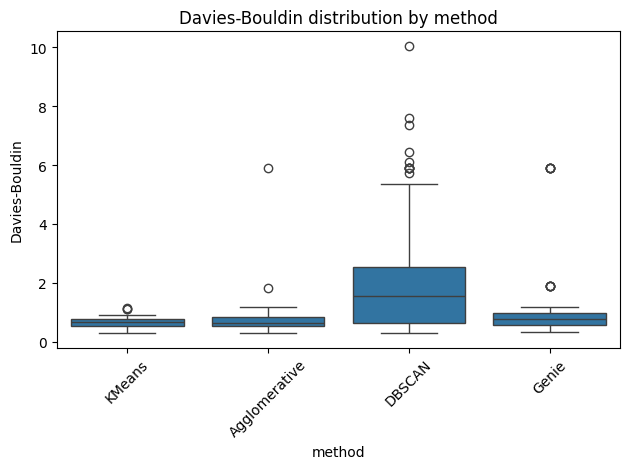

In [11]:
metrics = ['ARI','NMI','FMI','Silhouette','Calinski-Harabasz','Davies-Bouldin']

for metric in metrics:
    plt.figure()
    sns.boxplot(data=df, x='method', y=metric)
    plt.xticks(rotation=45)
    plt.title(f"{metric} distribution by method")
    plt.tight_layout()
    plt.show()

# Pairwise metrics for the algorithms, easy to plot and can yield insightful information

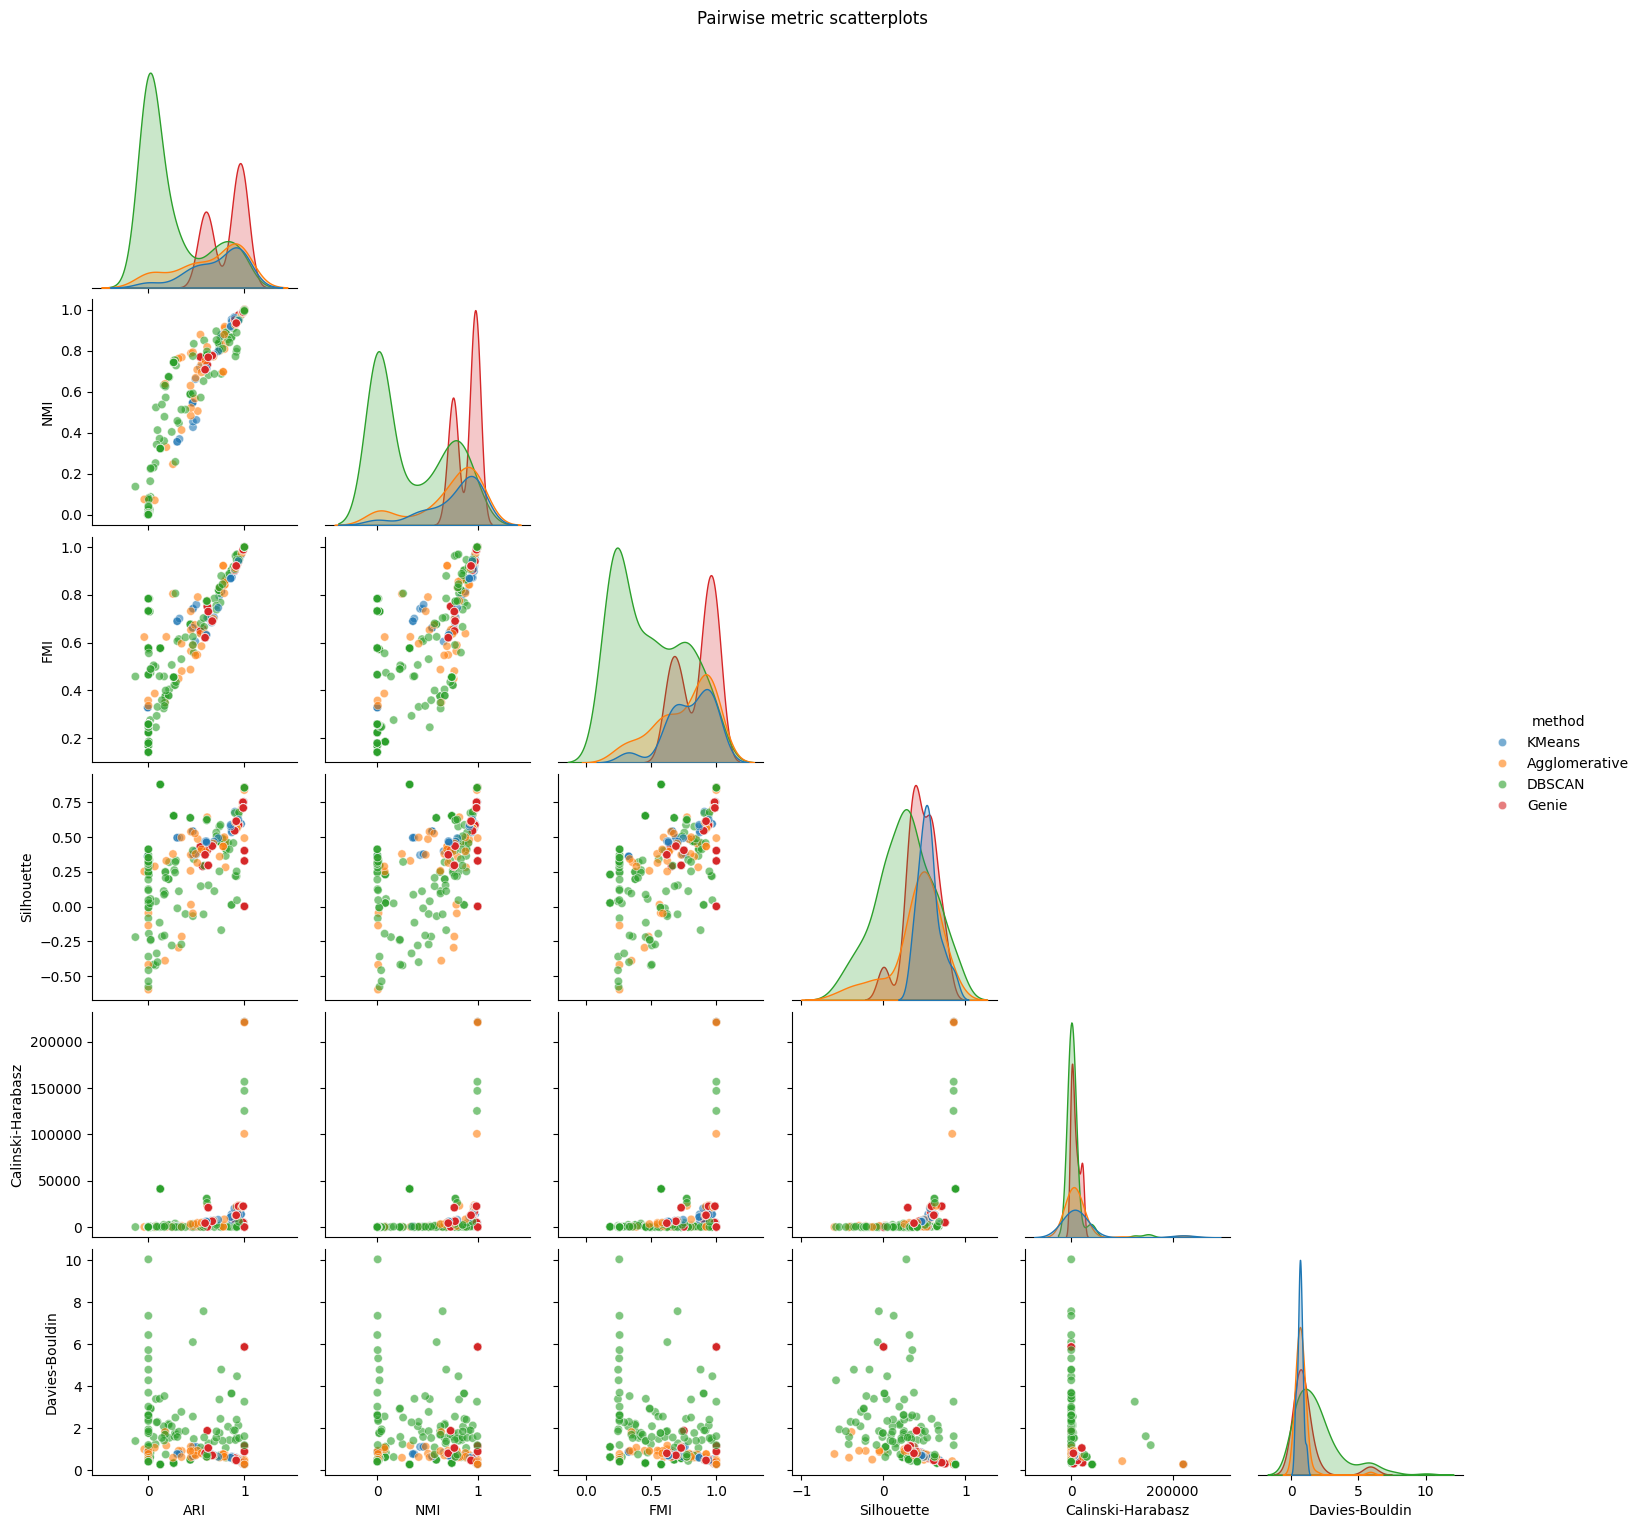

In [18]:
sns.pairplot(df, vars=metrics, hue='method', corner=True, plot_kws={'alpha':0.6})
plt.suptitle("Pairwise metric scatterplots", y=1.02)
plt.show()

# Normalized metrics (because some of them especially calinski-Harabasz is very large compared to ARI, NMI, and FMI that are in (0-1))

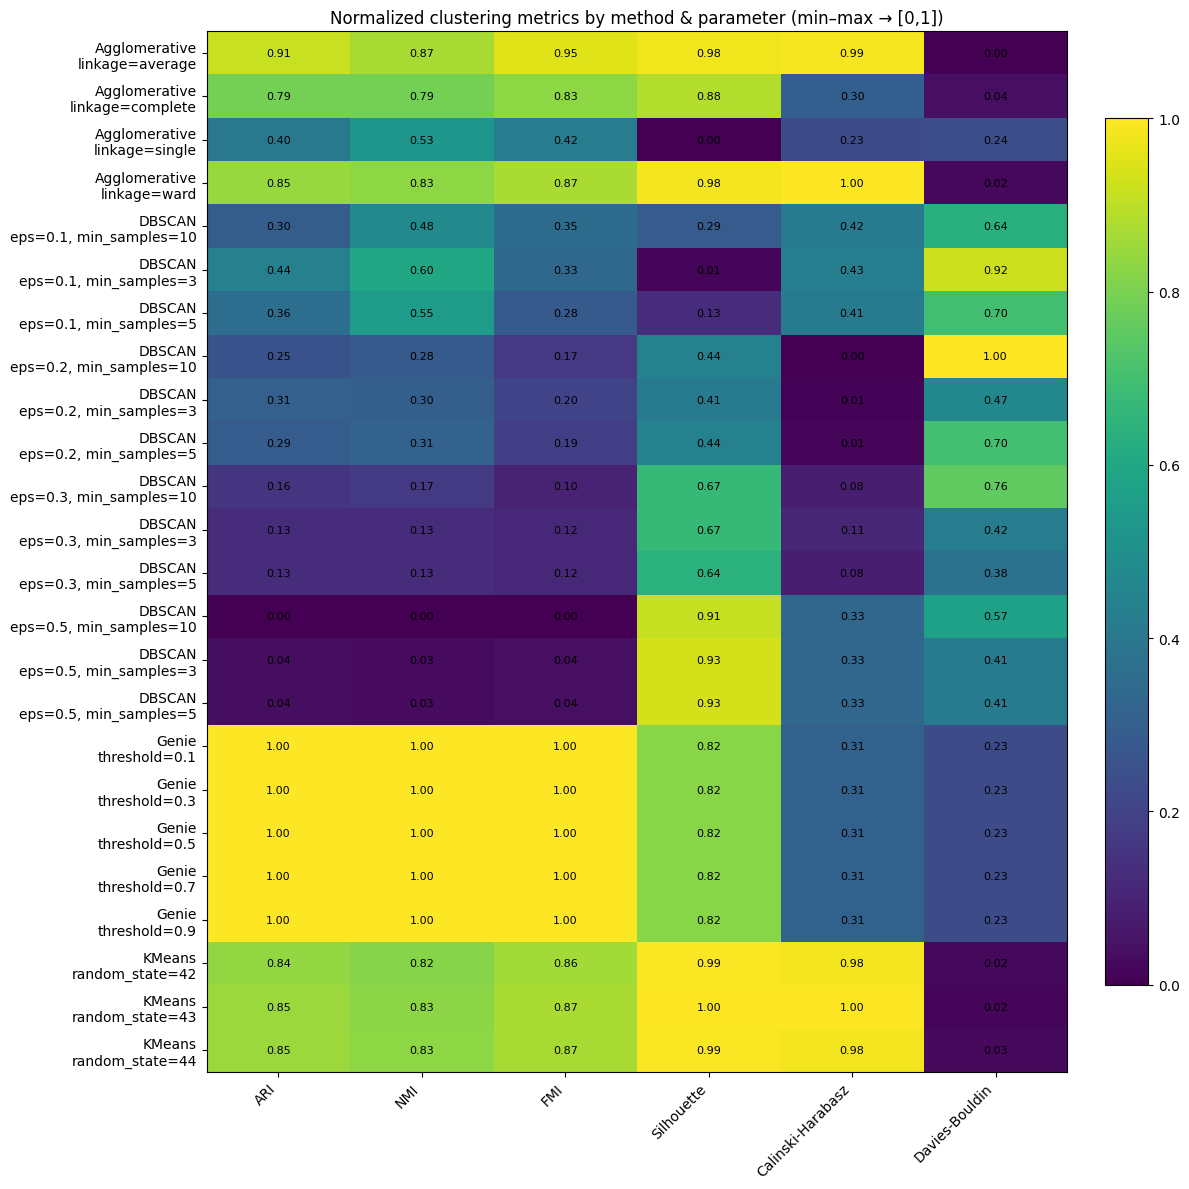

In [ ]:

df['method_param'] = df['method'] + '\n' + df['param']

metrics = ['ARI','NMI','FMI','Silhouette','Calinski-Harabasz','Davies-Bouldin']
mean_table = df.groupby('method_param')[metrics].mean()

norm_table = (mean_table - mean_table.min()) / (mean_table.max() - mean_table.min())

data = norm_table.values
rows = norm_table.index.tolist()
cols = metrics

fig, ax = plt.subplots(figsize=(12, max(4, len(rows)*0.5)))
im = ax.imshow(data, aspect='auto')

ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation=45, ha='right')
ax.set_yticks(np.arange(len(rows)))
ax.set_yticklabels(rows)

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        ax.text(j, i, f"{data[i, j]:.2f}",
                ha='center', va='center', fontsize=8)

ax.set_title("Normalized clustering metrics by method & parameter (min–max → [0,1])")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# Visualisation of the labels for different parameters and original labels for algorithms 

In [ ]:
import math
import matplotlib.pyplot as plt
import clustbench
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

#hyper-params
kmeans_seeds     = [42, 43, 44]
agg_linkages     = ['ward', 'complete', 'average', 'single']
dbscan_params    = {'eps': [0.3, 0.5, 0.8], 'min_samples': [3,5]}
genie_params     = [0.1, 0.2, 0.5, 0.7, 0/9]

def visualize_all(datasets, data_url, n_cols=4, figsize_per_plot=(4,4)):
    for name in datasets:
        bench = clustbench.load_dataset('sipu', name, url=data_url)
        X, y_true = bench.data, bench.labels[0]
        
        jobs = []
        # KMeans
        for seed in kmeans_seeds:
            jobs.append((f'KMeans\nseed={seed}',
                         KMeans(n_clusters=bench.n_clusters[0], random_state=seed)))
        # Agglomerative
        for link in agg_linkages:
            jobs.append((f'Agglo\n{link}',
                         AgglomerativeClustering(n_clusters=bench.n_clusters[0], linkage=link)))
        # DBSCAN
        for eps in dbscan_params['eps']:
            for ms in dbscan_params['min_samples']:
                jobs.append((f'DBSCAN\neps={eps},ms={ms}',
                             DBSCAN(eps=eps, min_samples=ms)))
        # Genie
        for t in genie_params:
            jobs.append((f'Genie\nthr={t}',
                         Genie(n_clusters=bench.n_clusters[0])))
        
        # how many plots? + 1 for original
        total = 1 + len(jobs)
        n_rows = math.ceil(total / n_cols)
        fig, axes = plt.subplots(n_rows, n_cols,
                                 figsize=(n_cols*figsize_per_plot[0],
                                          n_rows*figsize_per_plot[1]),
                                 squeeze=False)
        axes = axes.flatten()
        
        #original
        axes[0].scatter(X[:,0], X[:,1], c=y_true, s=10, cmap='tab10')
        axes[0].set_title(f'{name}\n(original)')
        axes[0].set_xticks([]); axes[0].set_yticks([])
        
        for i, (title, est) in enumerate(jobs, start=1):
            try:
                y_pred = est.fit_predict(X)
            except Exception as e:
                y_pred = np.zeros(len(X), dtype=int)
            
            ax = axes[i]
            ax.scatter(X[:,0], X[:,1], c=y_pred, s=10, cmap='tab10')
            ax.set_title(title, fontsize=8)
            ax.set_xticks([]); ax.set_yticks([])
        
        for j in range(total, len(axes)):
            axes[j].axis('off')
        
        plt.tight_layout()
        plt.show()


Processing dataset: Aggregation


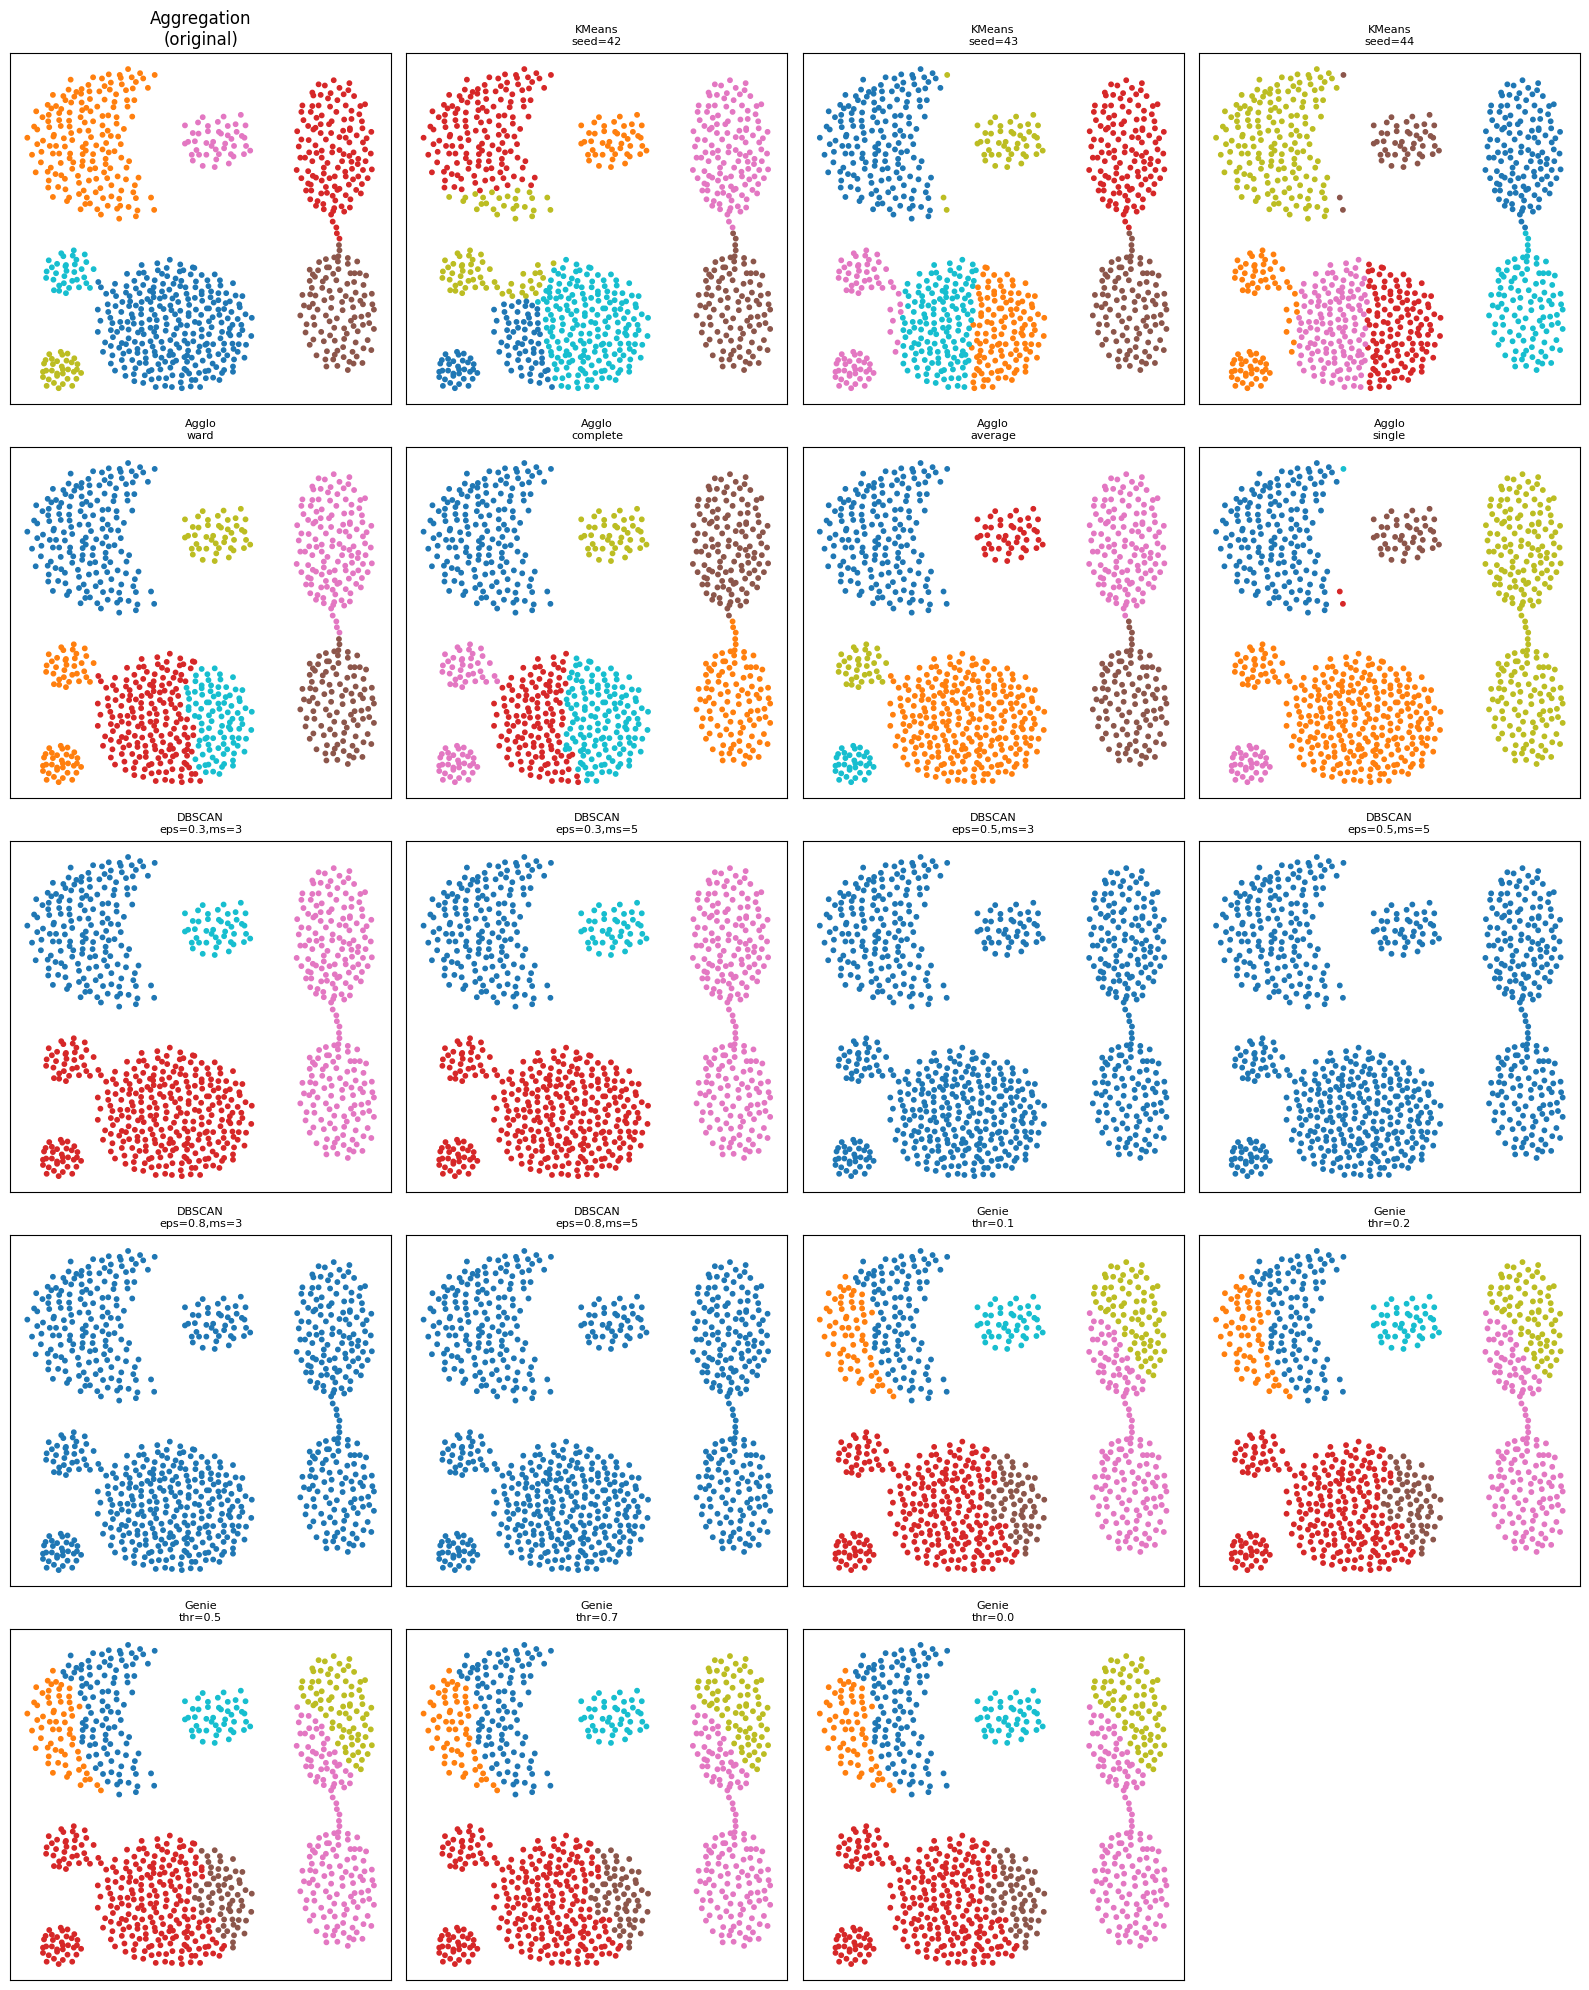

Processing dataset: Flame


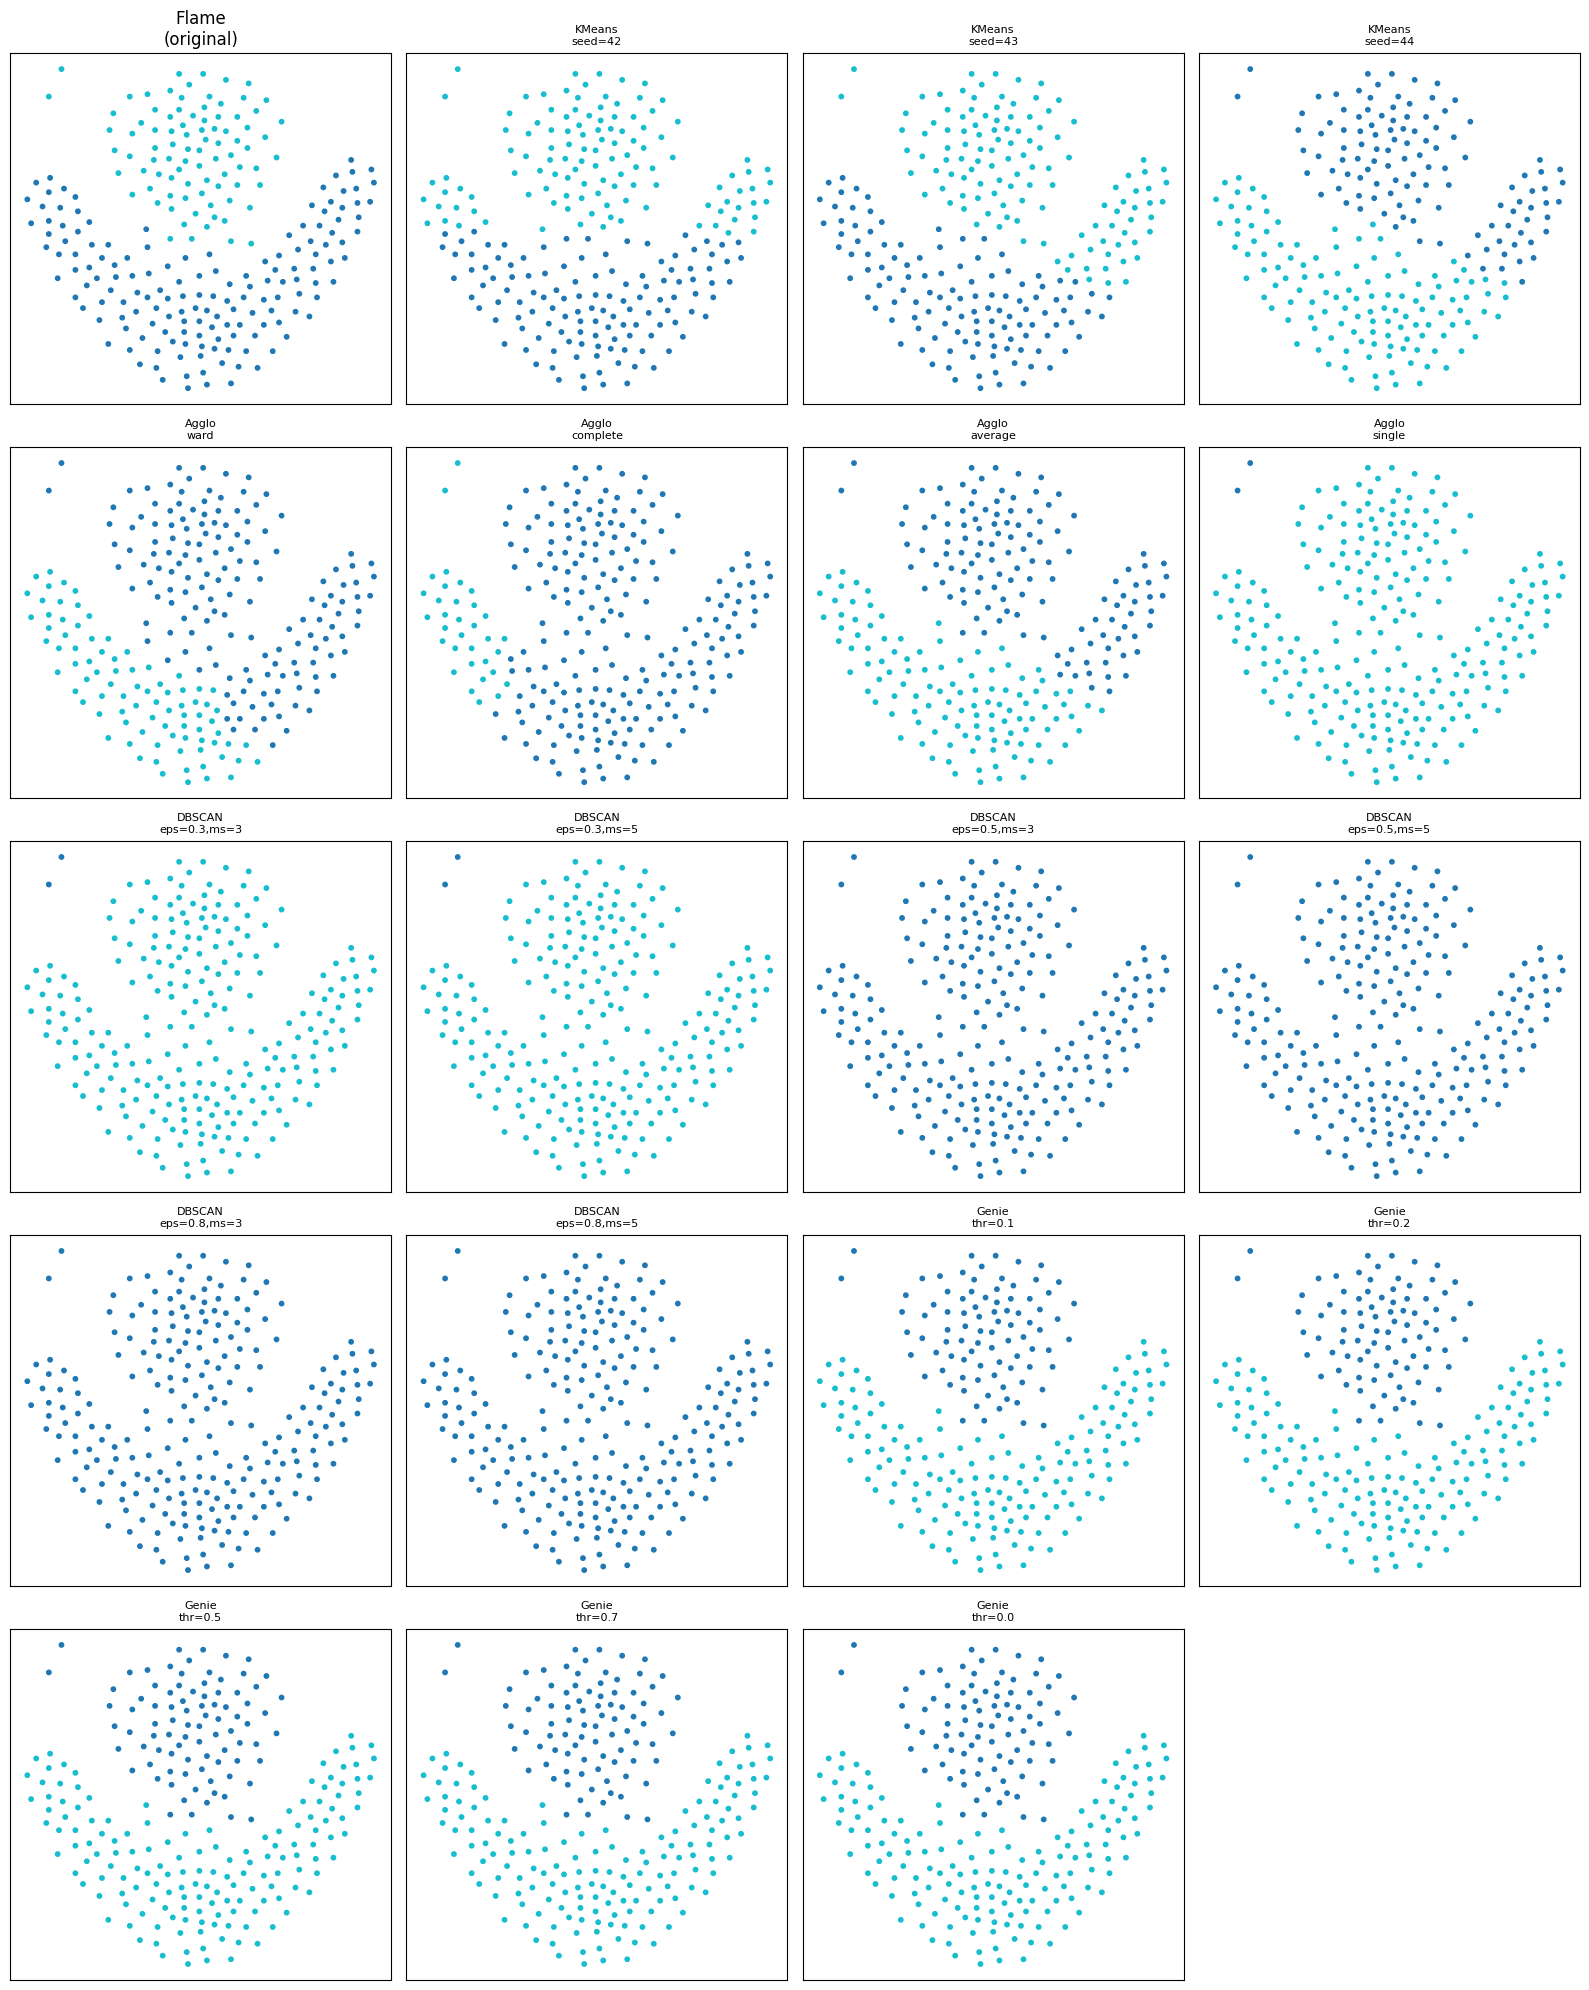

Processing dataset: Pathbased


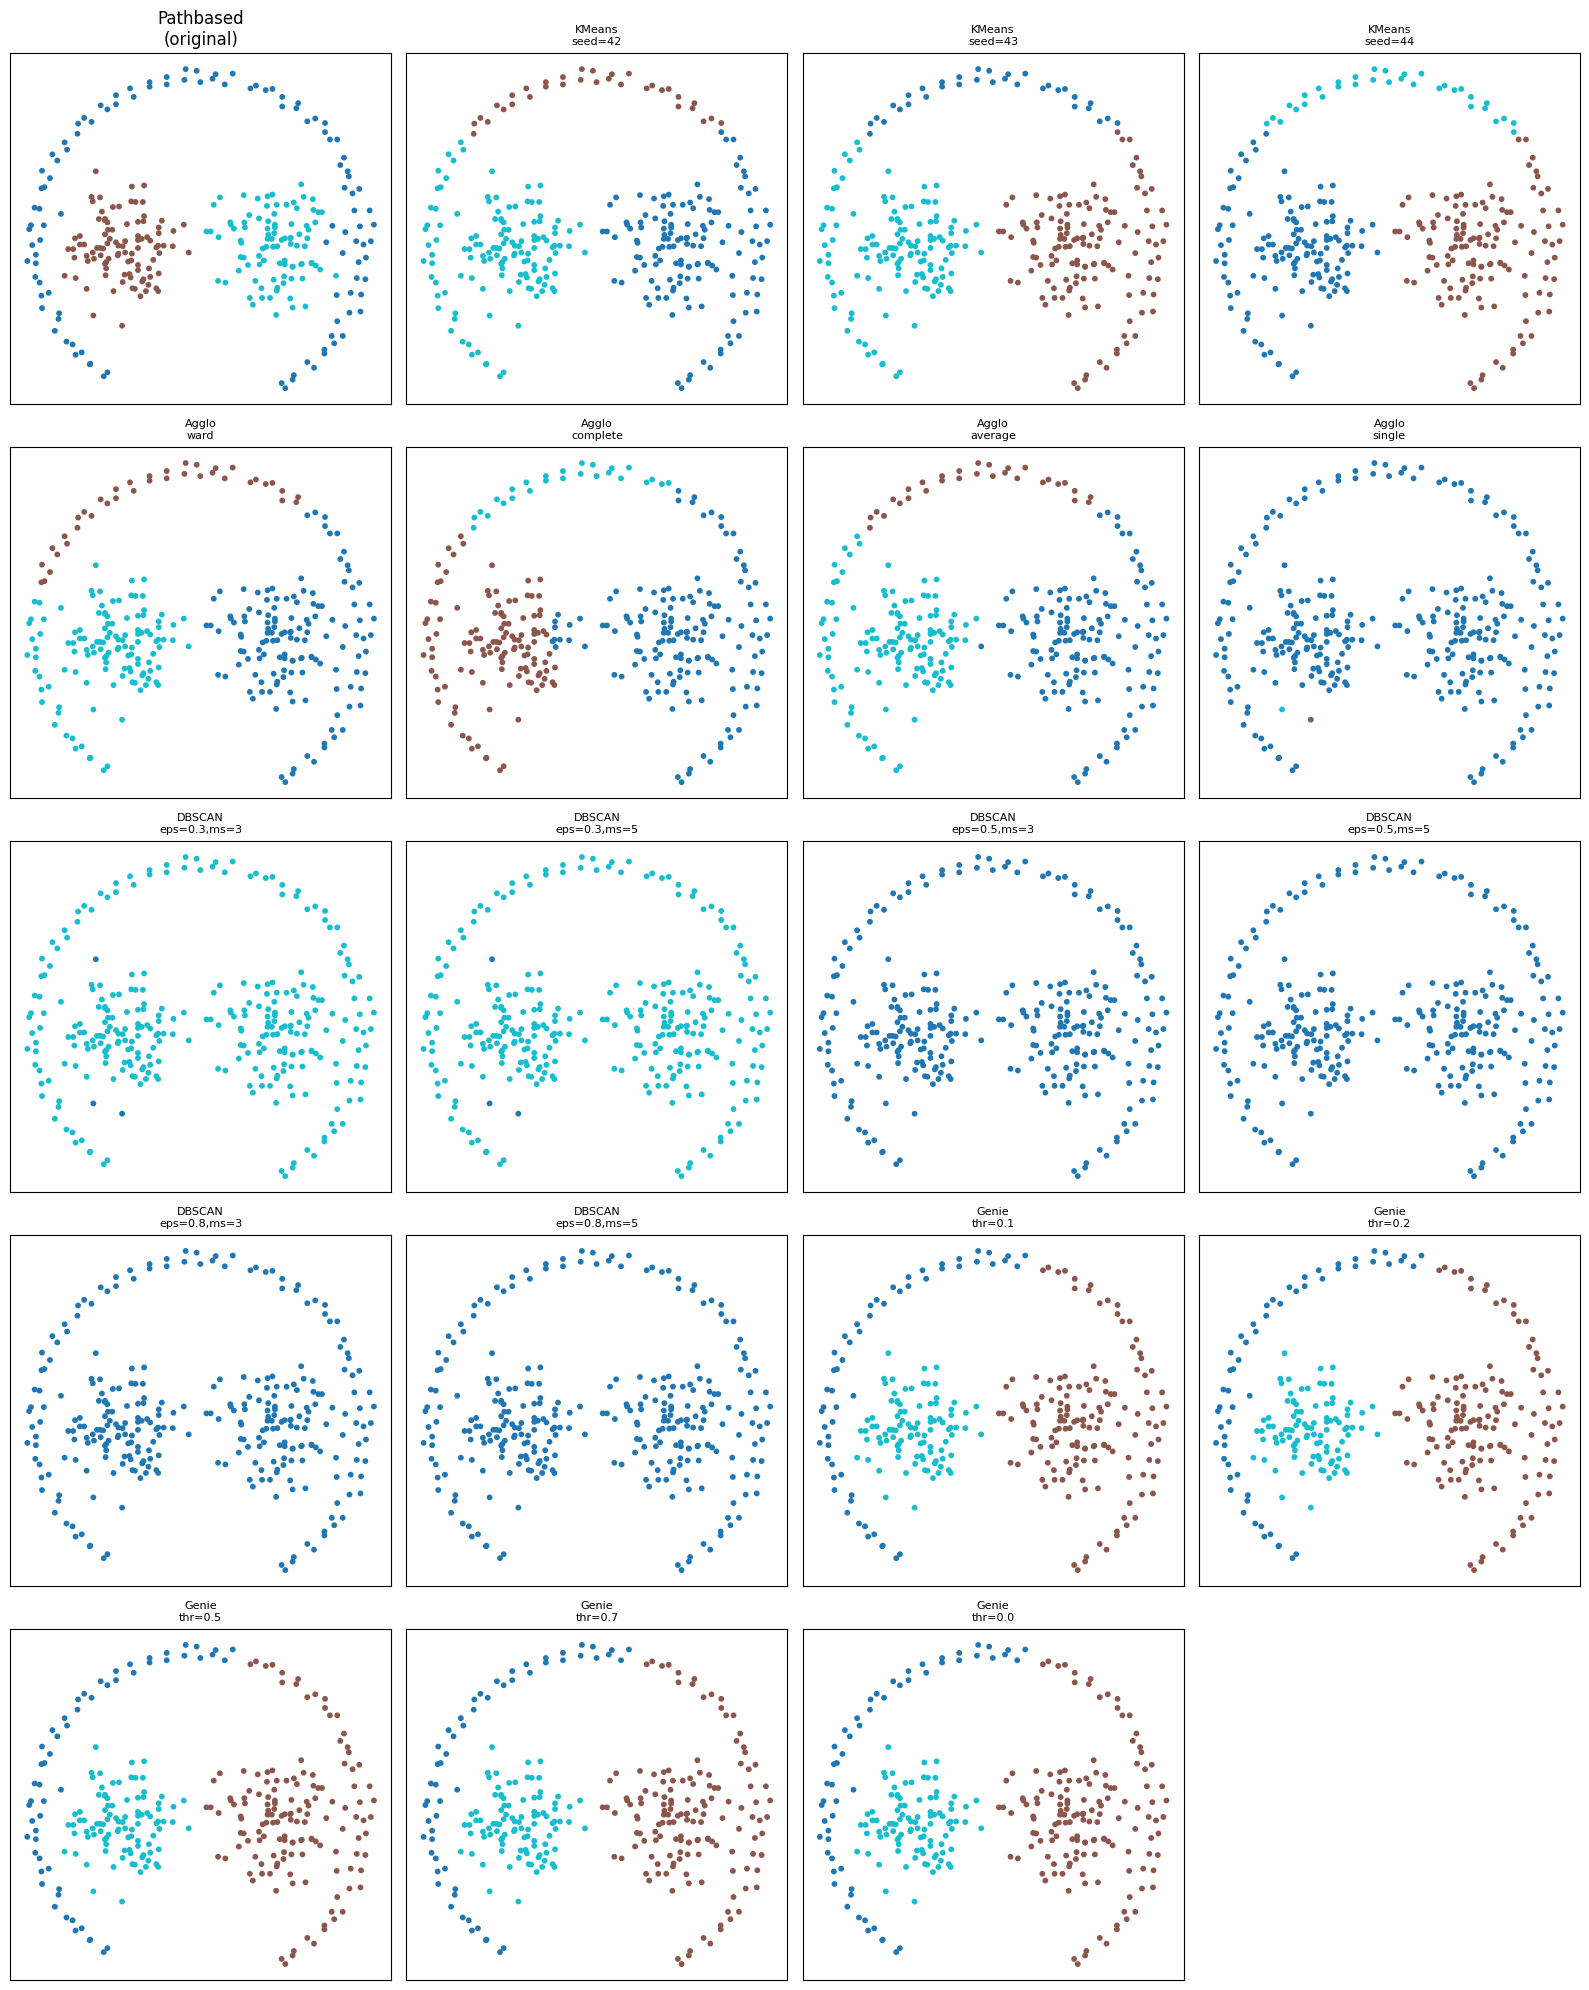

In [ ]:
datasets = ['Aggregation', 'Flame', 'Pathbased']

for dataset in datasets:
    print(f"Processing dataset: {dataset}")
    bench = clustbench.load_dataset('sipu', dataset, url=data_url)
    X, y_true = bench.data, bench.labels[0]
    
    visualize_all([dataset], data_url=data_url)
